In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as color
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1)

To make code more robust, I am re-writing the code from last unit. Changes include:
1. Including an electric field method inside the charge class

2. Including a separate function for termination criteria

3. Plotting inside the field line function

4. Generalizing so that the boundary conditions for dipoles (symmetric about x-axis) can be selected and un-selected. This allows for unbalanced charge configurations to be plotted (field lines can now terminate at the boundary)

5. Creating a separate function for the Euler method (and the RK2 method) for simpler implementation

In [44]:
class Charge:
    def __init__(self,x,y,q):
        self.x=x
        self.y=y
        self.q=q
        return
    def potential(self, xgrid, ygrid): 
        dx = xgrid - self.x
        dy = ygrid - self.y
        r = np.sqrt(dx**2 + dy**2)
        return self.q / r 
    
    def e_field(self, x, y):
        dx = x - self.x
        dy = y - self.y
        r = np.sqrt(dx**2 + dy**2)

        Ex = self.q * dx / r**3
        Ey = self.q * dy / r**3
        
        return Ex, Ey

In [45]:
def mplot(charges, xlim, ylim):
    _, ax = plt.subplots(1,1)

    for charge in charges:
        if charge.q > 0:
            c = "red"
        else:
            c = "blue"
        plt.scatter(charge.x, charge.y, c=c)
    
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.set_aspect('equal')

    ax.set_xticks(np.arange(-xlim, xlim, 1), minor=True)
    ax.set_yticks(np.arange(-ylim, xlim, 1), minor=True)
    ax.grid(which='both')
    ax.set_axisbelow(True)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    
    return ax

Note: there is now an option to toggle "dipole"; this allows field lines to terminate at boundary if there is no symmetry.

In [46]:
def termination(current, termination, xlim, ylim, tol, dip):
    x, y = current
    xterm, yterm = termination
    if dip == False:
        if x < -xlim or x > xlim or y < -ylim or y > ylim:
            return True

    d = np.hypot(x - xterm, y - yterm)
    if d < tol:
        return True
    
    return False

In [47]:
def  net_efield(x, y, charges):
    Ex, Ey = 0, 0
    for charge in charges:
        dE = charge.e_field(x,y)
        Ex += dE[0]
        Ey += dE[1]
   
    return Ex, Ey

In [48]:
def euler(xi, yi, Ex, Ey, h):
    xi += h * Ex/np.hypot(Ex, Ey)
    yi += h * Ey/np.hypot(Ex, Ey)
    return xi, yi

In [49]:
def rk2(xi, yi, Ex, Ey, h):
    k1x, k1y = Ex, Ey
    k2x, k2y = Ex + h * k1x, Ey + h * k1y
    
    xi += h * 0.5 * (k1x + k2x) / np.hypot((k1x + k2x), (k1y + k2y))
    yi += h * 0.5 * (k1y + k2y) / np.hypot((k1x + k2x), (k1y + k2y))
    
    return xi, yi

In [50]:
def field_line(start, end, lim, charges, method, color, h, ax, dip, tol):
    
    current = start[0], start[1]
    while True:
        
        Ex, Ey = net_efield(current[0], current[1], charges)

        if dip == True:
            if current[0] < -lim or current[0] > lim:
                current = (-current[0], current[1])

        if method == 'euler':
            new = euler(current[0], current[1], Ex, Ey,h)

        elif method == 'rk2':
            new = rk2(current[0], current[1], Ex, Ey, h)
        else:
            raise ValueError("Method should be 'euler' or 'rk2'.")
        
        if termination(new, end, lim, lim, tol, dip):
            break


        ax.plot([current[0], new[0]], [current[1], new[1]], c=color, linestyle="-")
        
        current = new
        
    return ax


In [51]:
def eq_points(n, radius, xc, yc):
    points = []
    for i in range(n):
        x = xc + radius * np.cos((2*np.pi*i)/n)
        y = yc + radius * np.sin((2*np.pi*i)/n)
        points.append((x, y))
    return points


## A)

Plotting RK2 and Euler for a dipole and step size of 0.5:

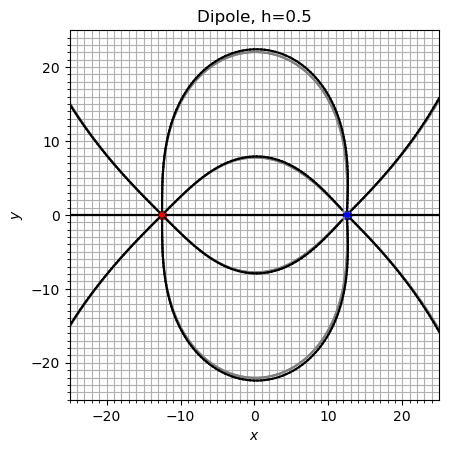

In [52]:
lim = 25 # Set limits of plot
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) # Set dipole position (horizontally symmetric about origin)
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) # Array of charges
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)
h = 0.5

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'gray', h, ax, True, 0.5)
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'euler', 'black', h, ax, True, 0.5)

ax.set_title("Dipole, h=0.5")

plt.show()



## B)

Plotting RK2 and Euler for a dipole and step size of 0.1:

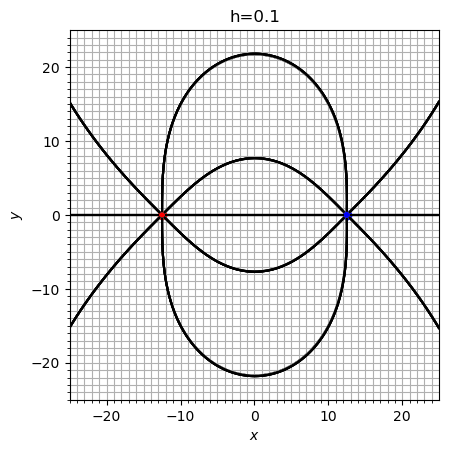

In [53]:
lim = 25 # Set limits of plot
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) # Set dipole position (horizontally symmetric about origin)
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) # Array of charges
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'gray', 0.1, ax, True, 0.5)
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'euler', 'black', 0.1, ax, True, 0.5)

ax.set_title("h=0.1")

plt.show()


## C)

1. When h is bigger, there is a more noticeable difference between the RK2 and Euler methods. As h gets smaller, there is less of a difference between the two. This is as expected, the Euler method has an error of $\mathcal{O}(h)$ while the RK2 method has an error of $\mathcal{O}(h^2)$. At smaller h's the difference between the two is less significant.

2. The runtime of RK2 is significantly larger than that of the Euler method. RK2 takes about twice as long (on average) as Euler does.

# 2)

## A)

Because dipole "toggle-ability" was introduced (above), there is no need to change code. Simply change charge configuration.

For a single positive charge at origin:

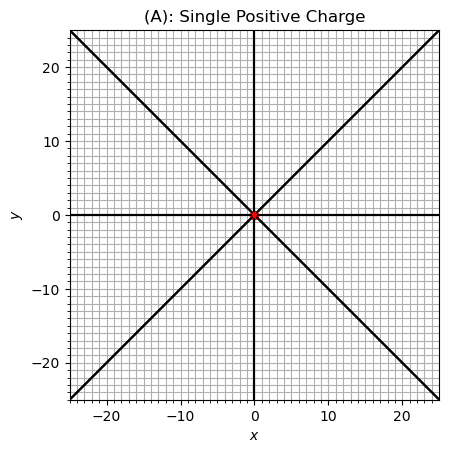

In [54]:
lim = 25
pos =np.array([Charge(0 , 0, 1)])
ax = mplot(pos, lim, lim)
h = 0.5
eq = eq_points(8, 0.5, pos[0].x, pos[0].y)

for point in eq:
        field_line(point, [0 , 0], lim, pos, 'rk2', 'black', h, ax, False, 0.5)

ax.set_title("(A): Single Positive Charge")

plt.show()


Makes sense physically---field lines are radially outwards.

## B)

For two positive charges:
- Note that field lines starting directly horizontally towards the other positive charge create infinite loops; they have been hard-coded out

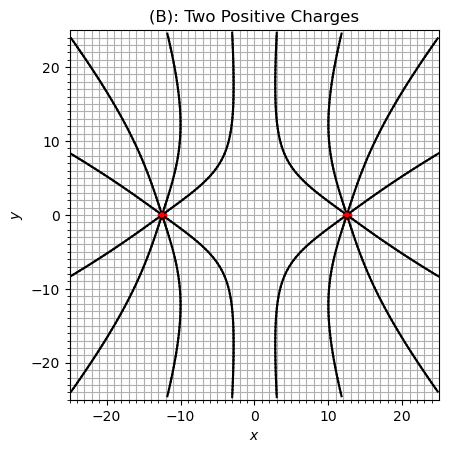

In [55]:
lim = 25
two_pos = np.array([Charge(12.5, 0, 1), Charge(-12.5, 0, 1)])

ax = mplot(two_pos, lim, lim)
h = 0.5
n = 10

eq1 = eq_points(n, 0.5, two_pos[0].x, two_pos[0].y)
eq2 = eq_points(n, 0.5, two_pos[1].x, two_pos[1].y)

for point1 in eq1:
        if abs(point1[1]-0) <= 0.1:
                continue
        field_line(point1, [0,0], lim, two_pos, 'euler', 'black', h, ax, False, 0.5)

for point2 in eq2:
        if abs(point2[1]-0)<= 0.1:
                continue
        field_line(point2, [0,0], lim, two_pos, 'euler', 'black', h, ax, False, 0.5)

ax.set_title("(B): Two Positive Charges")

plt.show()


Makes sense physically---there are no field lines pointing towards either of the charges from the other.

## C)

For two positive charges and one negative charge:

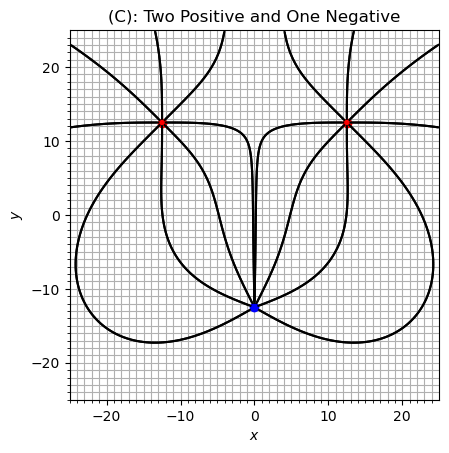

In [56]:
lim = 25
posneg = np.array([Charge(lim/2, lim/2, 1), Charge(-lim/2, lim/2, 1), Charge(0, -lim/2, -1)])

ax = mplot(posneg, lim, lim)
h = 0.5
n = 8

eq1 = eq_points(n, 0.5, posneg[0].x, posneg[0].y)
eq2 = eq_points(n, 0.5, posneg[1].x, posneg[1].y)

for point1 in eq1:
        field_line(point1, [posneg[2].x, posneg[2].y], lim, posneg, 'rk2', 'black', h, ax, False, 0.5)

for point2 in eq2:
        field_line(point2, [posneg[2].x, posneg[2].y], lim, posneg, 'rk2', 'black', h, ax, False, 0.5)

ax.set_title("(C): Two Positive and One Negative")

plt.show()


Makes sense physically, because the charges are all of the same magnitude, half of the field lines going out from the positive charges end at the negative charge.

# 3)

New termination criteria: removing option for field lines to terminate at boundary. For equipotential lines, want to teleport to symmetric point always.

In [57]:
def term(current, term, tol):
    
    d = np.hypot(current[0]-term[0], current[1]-term[1])
    if d < tol:
        return True
    
    return False

Plotting equipotentials:

In [58]:
def equipotential(start, charges, ax, h, lim, tol):
    current = start
    count  = 0
    
    while True:
        Ex, Ey = net_efield(current[0], current[1], charges)
        
        Exrot, Eyrot = Ey, -Ex

        new = rk2(current[0], current[1], Exrot, Eyrot, h)

        if count > 10:
            if term(new, start, tol):
                break
        
        if new[0] < -lim or new[0] > lim or new[1] < -lim or new[1] > lim:
            new = (np.clip(-new[0], -lim, lim), np.clip(-new[1], -lim, lim) )
            current = new
            continue


        ax.plot([current[0], new[0]], [current[1], new[1]], color="hotpink", linestyle="-")
        
        current = new
        count = count + 1
    
    return ax

Plotting a single equipotential around the negative charge:

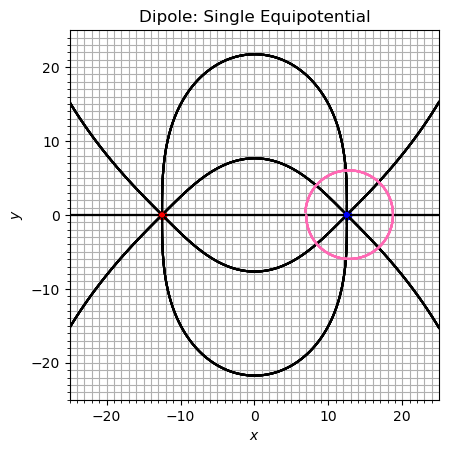

In [59]:
lim = 25 
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) 
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) 
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)
h = 0.1

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'black', h, ax, True, 0.5)

equipotential([7,0], dipole, ax, 0.1, lim, 0.35)
ax.set_title("Dipole: Single Equipotential")

plt.show()

# 4)

Function for calculating total potential for some array of x-values along y = 0:

In [60]:
def tot_potential(xgrid, charges):
    potentialslice = 0
    for charge in charges:
        potentialslice += charge.potential(xgrid, 0)
    return potentialslice

Note: levels were generated by looking at potslice output and creating an interval that more or less covers the potential between the two charges.

In [61]:
xgrid = np.linspace(-12.5, 12.5, 1000, endpoint=False)
potslice = tot_potential(xgrid, dipole)
levels = np.linspace(-0.24, 0.24, 7)
xvals = []

for level in levels:
    isabove = potslice > level
    i = np.argmin(isabove)
    xvals.append(xgrid[i])

Plot 7 equipotential lines between the dipoles. 
- Note: this is generalized to N equipotential lines; more than 7 equipotential lines don't increase information about the system meaningfully.

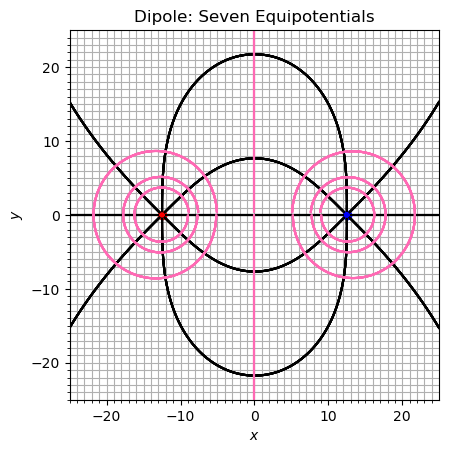

In [62]:
lim = 25 
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) 
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) 
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)
h = 0.1

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'black', h, ax, True, 0.5)

for val in xvals:
    equipotential([val, 0], dipole, ax, h, lim, 0.35)

ax.set_title("Dipole: Seven Equipotentials")
plt.show()
